In [2]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage as ndi
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [4]:
params = dict(
    experiment_dir="/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/",
    imaging_scheme="TL/470/410/470/410"
)

ex_unreg = experiment.PairExperiment(**params).full_pipeline()
# ex_reg = experiment.PairExperiment(**params, should_register=True).full_pipeline()

09:17:56 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
09:17:56 INFO:Loading Images
09:17:57 INFO:Segmenting pharynxes
09:17:58 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:07<00:00, 15.82it/s]
09:18:07 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 110.27it/s]
09:18:08 INFO:Measuring under midlines
100%|██████████| 123/123 [00:00<00:00, 123.05it/s]
09:18:09 INFO:Registering profiles
09:18:40 INFO:Trimming intensity data
09:18:41 INFO:Calculating redox measurements
09:18:41 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
09:18:41 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-06_frame_specific_midlines_with_registration/2017_02_22-HD233_SAY47-summary_table.csv
09:18:41 INFO:Saving profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02

In [6]:
def load_all_cached_profile_data(glob_pattern):
    return xr.concat((xr.load_dataarray(p) for p in sorted(meta_dir.glob(glob_pattern))), dim='strain')

meta_dir = Path("/Users/sean/code/pharynx_redox/data/paired_ratio")
raw_prof = load_all_cached_profile_data('**/*single_unreg/*.nc')
da.load_all_summaries(meta_dir)

df = da.load_all_summaries(meta_dir)
df = df.reset_index(drop=True)

df['total'] = df['anterior'] + df['posterior'] + df['sides_of_tip'] + df['tip']
df = df.pivot_table(index=['animal', 'experiment', 'strategy'], columns='pair').reset_index()

df = df.sort_values(['experiment', 'animal'])
df.index.rename('index', inplace=True)

df = df[df.strategy=='single_reg'].reset_index(drop=True)
df.index.rename('index', inplace=True)

df.head()

animal              experiment    strategy          410               \
pair                                                        0            1   
index                                                                        
0          0  2017_02_22-HD233_SAY47  single_reg  7867.316522  7913.949196   
1          1  2017_02_22-HD233_SAY47  single_reg  8240.370640  8628.224280   
2          2  2017_02_22-HD233_SAY47  single_reg  9125.879916  9084.437211   
3          3  2017_02_22-HD233_SAY47  single_reg  8319.834159  8352.095984   
4          4  2017_02_22-HD233_SAY47  single_reg  8490.935634  8318.103119   

               470              anterior              e  ... posterior     \
pair             0            1        0  1           0  ...         0  1   
index                                                    ...                
0      5522.521894  5531.857693        0  0 -270.618116  ...         0  0   
1      5701.835700  5970.328106        0  1 -270.083542  ...         0  1   
2      6679.055468  6569.959972        0  0 -272.164406  ...         0  0   
3      5594.121760  5567.273572        0  0 -269.144020  ...         0  0   
4      5679.523530  5576.936311        0  0 -268.735133  ...         0  0   

              r           sides_of_tip    tip    total     
pair          0         1            0  1   0  1     0  1  
index                                                      
0      1.428143  1.435046            0  0   1  0     1  0  
1      1.449376  1.450312            1  1   0  1     1  4  
2      1.366817  1.382932            0  0   0  0     0  0  
3      1.492789  1.504509            0  0   0  0     0  0  
4      1.511920  1.511042            0  0   0  0     0  0  

[5 rows x 23 columns]

In [7]:
nomove = df[(df['total'][0] == 0) & (df['total'][1] == 0)].index.values

nonmovers = raw_prof[nomove]

In [8]:
def pad(d, lpad=10, rpad=10):
    return np.pad(d, ((0,0), (lpad, rpad)), mode='edge')

i410_0 = pad(nonmovers.sel(wavelength='410', pair=0), lpad=10)[:10]
i410_1 = pad(nonmovers.sel(wavelength='410', pair=1), lpad=10)
i470_0 = pad(nonmovers.sel(wavelength='470', pair=0), lpad=10)
i470_1 = pad(nonmovers.sel(wavelength='470', pair=1), lpad=10)

In [7]:
shifts = [0, 1, 1.5, 2, 2.5, 3, 3.5]
s410 = np.stack([scipy.ndimage.shift(i410_0, (0, s), mode='nearest') for s in shifts], axis=0)

d_orig = []
d_shift = []

    for i in tqdm_notebook(range(s410.shape[0])):
    f_orig, f_shift, w = profile_processing.register_pair(
        s410[0], s410[i],
        smooth_nbasis=50, rough_nbasis=200, warp_lam=0.1, smooth_lambda=1e-5, rough_lambda=1e-7)
    
    d_orig.append(np.squeeze(f_orig.data_matrix))
    d_shift.append(np.squeeze(f_shift.data_matrix))
    
d_orig = np.array(d_orig)
d_shift = np.array(d_shift)

In [8]:
from matplotlib.transforms import Bbox, TransformedBbox, \
    blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
    BboxConnectorPatch


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect01(ax1, ax2, ymin, ymax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transData)
    trans2 = blended_transform_factory(ax2.transData, ax2.transData)

    xmin1 = ax1.viewLim.get_points()[0,0]
    xmin2 = ax2.viewLim.get_points()[0,0]
    xmax1 = ax1.viewLim.get_points()[1,0]
    xmax2 = ax2.viewLim.get_points()[1,0]
    
    bbox = Bbox.from_extents(xmax1, ymin, xmin1, ymax)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.1}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=1, loc1b=3, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

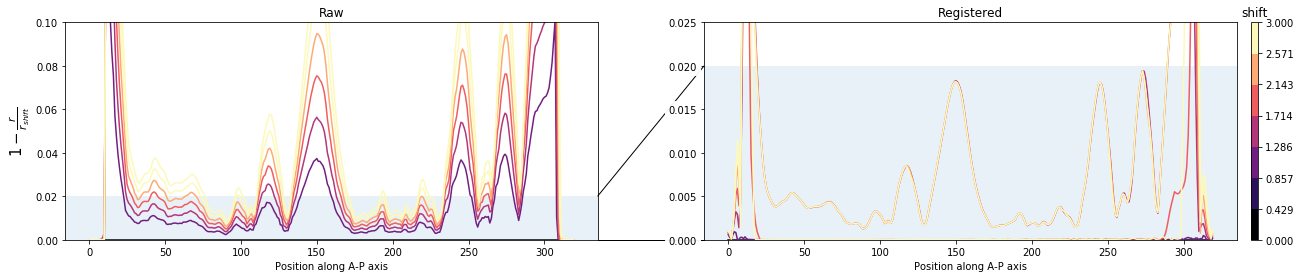

In [10]:
# norm = mpl.colors.Normalize(vmin=0, vmax=10)
norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0, 3, len(shifts)+1), ncolors=256)
cmap = cm.magma
newcmp = ListedColormap(cmap(np.linspace(0, .99, 256)))
m = cm.ScalarMappable(norm=norm, cmap=newcmp)

fig, axes = plt.subplots(1,2, figsize=(25,4), sharex='all');


for i in range(s410.shape[0]):
    axes[0].plot(np.mean(np.abs(1 - (s410[i] / s410[0])), axis=0), label=i, color=m.to_rgba(shifts[i]))
    axes[1].plot(np.mean(np.abs(1 - (d_shift[i] / d_orig[i])), axis=0), label=i, color=m.to_rgba(shifts[i]), linestyle='-')


axes[0].set_ylim(0,.1)
axes[1].set_ylim(0,.025)

# axes[0].axhline(0.02, color='k', linestyle='--')
zoom_effect01(axes[0], axes[1], ymin=0, ymax=0.02)

axes[0].set_title('Raw')
axes[1].set_title('Registered')
axes[0].set_ylabel(r'$1 - \frac{r}{r_{shift}}$', fontsize=15)
axes[0].set_xlabel('Position along A-P axis')
axes[1].set_xlabel('Position along A-P axis')

# plt.tight_layout()
axcb = plt.colorbar(m, ax=axes.ravel().tolist(), pad=0.01, aspect = 30)
axcb.ax.set_title('shift');

bbox = dict(ec='none', fc="white", alpha=0.95)
plt.setp(axes[1].get_yticklabels(), bbox=bbox)

plt.savefig('/Users/sean/Desktop/fig_lam=0.3.pdf')

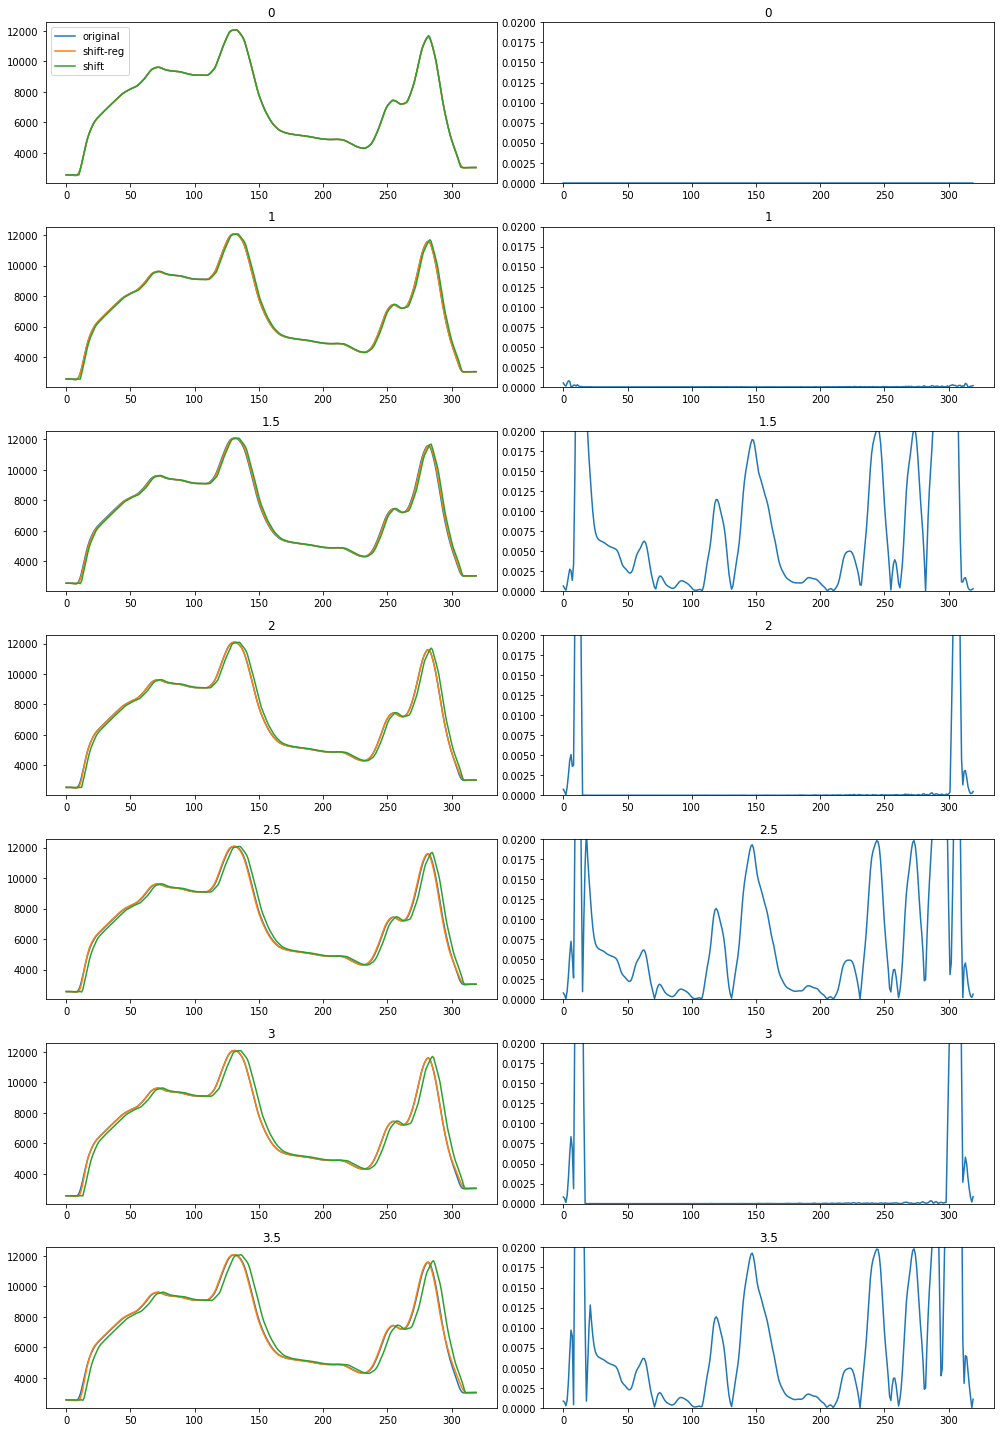

In [11]:
si = 2;
i = 1;
fig, axes = plt.subplots(len(shifts), 2, figsize=(14,20))
for si in range(len(shifts)):
    axes[si][0].plot(d_orig[si][i].T, label='original');
    axes[si][0].plot(d_shift[si][i].T, label='shift-reg');
    axes[si][0].plot(s410[si][i].T, label='shift');

    
    axes[si][1].plot(np.abs(1- (d_orig[si][i] / d_shift[si][i].T)));
    
    axes[si][0].set_title(shifts[si]);
    axes[si][1].set_title(shifts[si]);
    axes[si][1].set_ylim(0,.02)
    

axes[0][0].legend();    
plt.tight_layout();

plt.savefig('/Users/sean/Desktop/weird.pdf')

# Shift Midlines

In [14]:
exp_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/"
imaging_scheme = "TL/470/410/470/410"
ex = experiment.PairExperiment(exp_dir, imaging_scheme, should_register=False)
ex.full_pipeline()

09:59:12 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation
09:59:12 INFO:Loading Images
09:59:12 INFO:Segmenting pharynxes
09:59:14 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:09<00:00, 13.84it/s]
09:59:24 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 116.48it/s]
09:59:25 INFO:Measuring under midlines
100%|██████████| 123/123 [00:01<00:00, 116.36it/s]
09:59:26 INFO:Trimming intensity data
09:59:27 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
09:59:27 INFO:Saving 2019_04_03_ASI_ablation inside /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation
09:59:27 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/analyses/2019-09-03_frame_specific_midlines_w

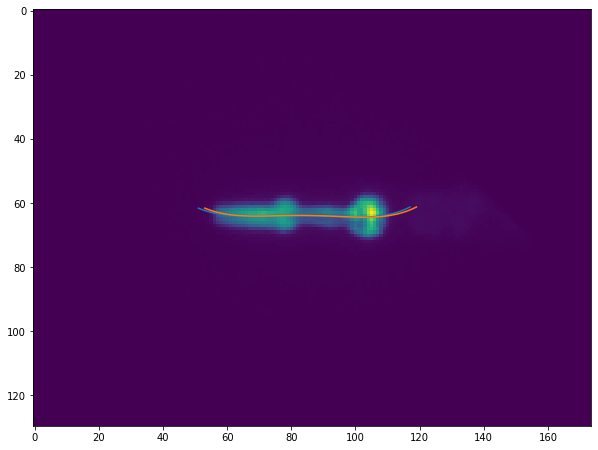

In [32]:
coords = ex.midlines[0]['470'][0].linspace();
plt.figure(figsize=(10,10));
plt.imshow(ex.rot_fl[0,1,0]);
plt.plot(coords[0], coords[1]);
dx, dy = 2, 0
plt.plot(coords[0] + dx, coords[1] + dy);

In [258]:
mid = ex.midlines[0]['410'][0]
fl = ex.rot_fl.sel(wavelength='410', pair=0).isel(strain=0)

n_points = 300
interp_order = 1

xs, ys = mid.linspace(n_points)
fl = np.asarray(fl)
dxs = np.linspace(-3, 3, 7)
dys = np.linspace(0, 0, 3)

all_combs_dxdy = np.array(np.meshgrid(np.unique(dxs), np.unique(dys))).T.reshape(-1,2)

unshifted_profs = np.zeros((len(all_combs_dxdy), n_points))
shifted_profs = np.zeros((len(all_combs_dxdy), n_points))

for i, (dx, dy) in enumerate(all_combs_dxdy):
    unshifted_profs[i] = ndi.map_coordinates(fl, np.stack([ys, xs]), order=interp_order)
    shifted_profs[i] = ndi.map_coordinates(fl, np.stack([ys + dy, xs + dx]), order=interp_order)

In [434]:
r_unshifted = []
r_shifted = []
shifts = []

dxs = np.linspace(-2, 2, 11)
dys = np.linspace(0, 0, 11)

for animal in tqdm_notebook(ex.rot_fl.sel(wavelength='410', pair=0)):
    
    all_combs_dxdy = np.array(np.meshgrid(np.unique(dxs), np.unique(dys))).T.reshape(-1,2)

    unshifted_profs = np.zeros((len(all_combs_dxdy), n_points))
    shifted_profs = np.zeros((len(all_combs_dxdy), n_points))
    
    for i, (dx, dy) in enumerate(all_combs_dxdy):
        unshifted_profs[i] = ndi.map_coordinates(animal, np.stack([ys, xs]), order=interp_order)
        shifted_profs[i] = ndi.map_coordinates(animal, np.stack([ys + dy, xs + dx]), order=interp_order)
        
        r_u, r_s, w = profile_processing.register_pair(unshifted_profs[i], shifted_profs[i], rough_nbasis=64)
        r_unshifted.append(r_u)
        r_shifted.append(r_s)
        shifts.append(all_combs_dxdy[i])
    
r_unshifted = reduce(lambda x, y: x.concatenate(y), r_unshifted)
r_shifted = reduce(lambda x, y: x.concatenate(y), r_shifted)

In [476]:
dxs = np.linspace(-2, 2, 11)
dys = np.linspace(0, 0, 11)

unshifted_profs = []
shifted_profs = []
for animal in tqdm_notebook(ex.rot_fl.sel(wavelength='410', pair=0)):
    all_combs_dxdy = np.array(np.meshgrid(np.unique(dxs), np.unique(dys))).T.reshape(-1,2)
    
    for i, (dx, dy) in enumerate(all_combs_dxdy):
        unshifted_profs.append(ndi.map_coordinates(animal, np.stack([ys, xs]), order=interp_order))
        shifted_profs.append(ndi.map_coordinates(animal, np.stack([ys + dy, xs + dx]), order=interp_order))

unshifted_profs = np.array(unshifted_profs)
shifted_profs = np.array(shifted_profs)

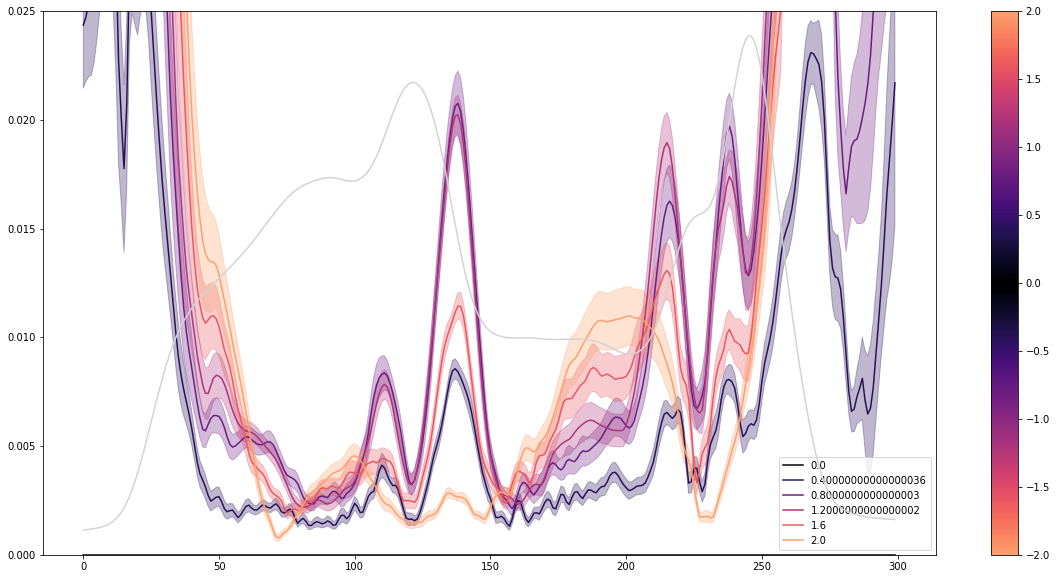

In [528]:
norm = mpl.colors.DivergingNorm(vmin=min(dxs), vmax=max(dxs), vcenter=0)
colors1 = cm.magma_r(np.linspace(.2, 1, 128))
colors2 = cm.magma(np.linspace(0, .8, 128))
colors = np.vstack((colors1, colors2))
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(20,10))


errs_reg = np.abs(1 - (r_unshifted / r_shifted)).data_matrix
errs_unreg = np.abs(1- (unshifted_profs / shifted_profs))
for dx in dxs:
    if dx >= 0:
        plots.plot_profile_avg_with_bounds(np.squeeze(errs_reg[np.array(shifts)[:,0] == dx]), color=m.to_rgba(dx), ax=plt.gca(), label=dx)
plt.colorbar(m);
plt.ylim(0,0.025);
plt.gca().legend();
# plots.add_regions_to_axis(regions=ex.scaled_regions, ax=plt.gca());

other = plt.twinx();
plt.plot(np.squeeze(np.mean(r_unshifted.data_matrix, axis=0)), color='lightgray');
other.set_axis_off();

In [ ]:
# norm = mpl.colors.Normalize(vmin=0, vmax=10)
norm = mpl.colors.BoundaryNorm(boundaries=np.linspace(0, 2, len(shifts)+1), ncolors=256)
cmap = cm.magma
newcmp = ListedColormap(cmap(np.linspace(0, .7, 256)))
m = cm.ScalarMappable(norm=norm, cmap=newcmp)

fig, axes = plt.subplots(1,2, figsize=(25,4), sharex='all');

errs_reg = np.squeeze(np.abs(1 - (r_unshifted / r_shifted)).data_matrix)
errs_unreg = np.abs(1- (unshifted_profs / shifted_profs))

for dx in dxs:
    if dx >= 0:
        plots.plot_profile_avg_with_bounds(np.squeeze(errs_reg[np.array(shifts)[:,0] == dx]), color=m.to_rgba(dx), ax=axes[1], label=dx)
        plots.plot_profile_avg_with_bounds(np.squeeze(errs_unreg[np.array(shifts)[:,0] == dx]), color=m.to_rgba(dx), ax=axes[0], label=dx)

axes[0].set_ylim(0,.4)
axes[1].set_ylim(0,.025)

axes[0].axhline(0.02, color='k', linestyle='--')
zoom_effect01(axes[0], axes[1], ymin=0, ymax=0.02);

axes[0].set_title('Raw')
axes[1].set_title('Registered')
axes[0].set_ylabel(r'$|1 - \frac{r}{r_{shift}}|$', fontsize=15)
axes[0].set_xlabel('Position along A-P axis')
axes[1].set_xlabel('Position along A-P axis')

# plt.tight_layout(rect=[0, 1, 1, 1])
axcb = plt.colorbar(m, ax=axes.ravel().tolist(), pad=0.01, aspect = 30)
axcb.ax.set_title('shift');

bbox = dict(ec='none', fc="white", alpha=0.95)
plt.setp(axes[1].get_yticklabels(), bbox=bbox);

plt.suptitle('Effect of Registration on Synthetically Shifted Midlines', fontsize=15);
# plt.subplots_adjust(top=0.85)
plt.savefig('/Users/sean/Desktop/reg_synth_shift_midlines.pdf')

In [585]:
plt.figure(figsize=(15,10))

shifts = np.array(np.meshgrid(np.unique(dxs), np.unique(dys))).T.reshape(-1,2)
data = errs_unreg - errs_reg
shifts = np.tile(shifts, len(data) / len(shifts))
for dx in dxs:
    if dx >= 0:
        plots.plot_profile_avg_with_bounds(
            np.squeeze(data[np.array(shifts)[:,0] == dx]),
            ax=plt.gca(), color=m.to_rgba(dx), label=f'shift={dx:.2f}')

plt.gca().legend();
plt.ylim(0,.4);
plt.ylabel('Reg. Error - Unreg. Error', fontsize=13);
plt.xlabel('Position along A-P axis', fontsize=13);
plt.gca().set_title('Registration decreases error across the pharynx for all shifts');
other = plt.twinx();
plt.plot(np.squeeze(np.mean(r_unshifted.data_matrix, axis=0)), color='lightgray');
other.set_axis_off();

plt.savefig('/Users/sean/Desktop/meeting_09_04_19/reg_error_minus_ureg_error.pdf');

TypeError: 'float' object cannot be interpreted as an integer

<Figure size 1080x720 with 0 Axes>

# RMSE(warp, identity) correlation with shift

In [586]:
dxs = np.linspace(-2, 2, 7)
dys = np.zeros(11)

warps = []
shifts = []
for animal in tqdm_notebook(ex.rot_fl.sel(wavelength='410', pair=0)):
    
    all_combs_dxdy = np.array(np.meshgrid(np.unique(dxs), np.unique(dys))).T.reshape(-1,2)

    unshifted_profs = np.zeros((len(all_combs_dxdy), n_points))
    shifted_profs = np.zeros((len(all_combs_dxdy), n_points))
    
    for i, (dx, dy) in enumerate(all_combs_dxdy):
        unshifted_profs[i] = ndi.map_coordinates(animal, np.stack([ys, xs]), order=interp_order)
        shifted_profs[i] = ndi.map_coordinates(animal, np.stack([ys + dy, xs + dx]), order=interp_order)
        
        r_u, r_s, w = profile_processing.register_pair(unshifted_profs[i], shifted_profs[i], rough_nbasis=64)
        warps.append(w)
        shifts.append(all_combs_dxdy[i])

In [ ]:
plt.plot(iden - warps[0].data_matrix)

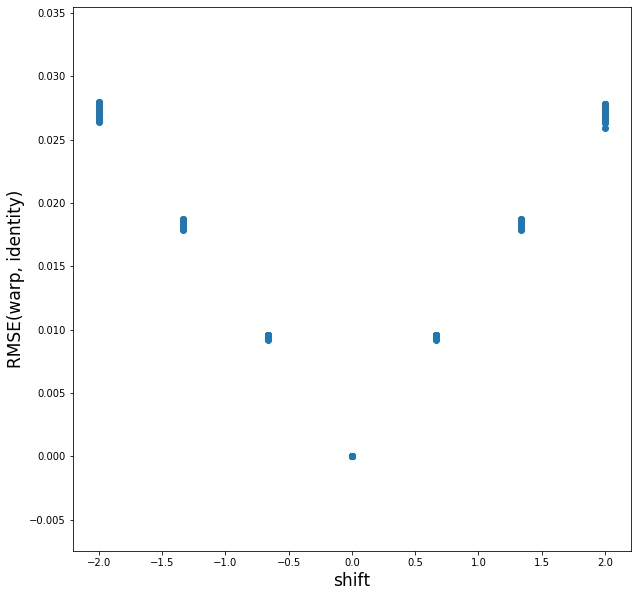

In [617]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(shifts)[:,0], np.squeeze(np.array(rmses)), alpha=1)
plt.xlabel('shift', fontsize=17)
plt.ylabel('RMSE(warp, identity)', fontsize=17)
plt.savefig('/Users/sean/Desktop/meeting_09_04_19/rmse_warp_shift.pdf')